In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from copy import deepcopy
import matplotlib.pyplot as plt

In [3]:
%%time
df = pd.read_csv("../input/blocks.csv")

Wall time: 754 ms


In [4]:
print(df.shape)
df.head()

(2273345, 7)


,Level,latBlock,lngBlock,month,day,hour,ClientMacAddr
0,0,0,20,4,1,10,1
1,0,0,20,4,2,16,1
2,0,0,20,4,3,10,1
3,0,0,20,4,3,16,1
4,0,0,20,4,3,17,1


In [5]:
df_val = df.loc[df.month>=6]
df = df.loc[df.month<6]
print(df_val.shape)
print(df.shape)

(965179, 7)
(1308166, 7)


In [31]:
%%time
# format the input and output
def matrixTrans(df, level, between=7):
    tf = deepcopy(df.loc[df['Level'] == level])
    latMax = tf.latBlock.max()+1
    lngMax = tf.lngBlock.max()+1
    tf["order"] = tf.month * 10**2+ tf.day
    orders = sorted(tf["order"].unique())

    def generator():
        for hour in tf.hour.unique():
            yield hour

    g = generator()
    num = 0
    for h in g:
        num+= len(orders)-between
    features = np.zeros((num,lngMax,latMax,between))
    labels = np.zeros((num,lngMax,latMax))
    
    g = generator()
    index = 0
    for hour in g:
        temp = tf.loc[(tf.hour==hour)]
        for i in range(between, len(orders)):
            next_ = temp.loc[tf.order==orders[i]]
            for _,row in next_.iterrows():
                labels[index, row['lngBlock'],row['latBlock']] = row['ClientMacAddr']
            for b in range(between):
                prev = temp.loc[tf.order==orders[i-1-b]]
                for _, row in prev.iterrows():
                    features[index, row['lngBlock'],row['latBlock'],b] = row['ClientMacAddr']
            index += 1
            if index==num:
                return features, labels

    del tf
    features = features[:index,:,:,:]
    labels = labels[:index,:,:]
    return features, labels

features, labels = matrixTrans(df, 0)
features_val, labels_val = matrixTrans(df_val, 0)
print(features.shape)
print(labels.shape)

(1224, 60, 20, 7)
(1224, 60, 20)
Wall time: 4min 20s


In [52]:
def cnn_model(features, labels, mode):
    # Input Layer
    size = features.shape
    kernel_size = [(3,3),(2,2),(2,2),(1,1)]
    #pool_size = parameters.get("pool_size", [(2,2),(3,3),(2,2)])
    strides = [1,1,1]
    filters = [32, 32, 16,1]

    input_layer = tf.reshape(features, [-1, size[1], size[2], size[3]])
    label_layer = tf.reshape(labels, [-1, size[1]*size[2]])

    # We only add conv layers with 'same' padding in our model
    # since It's a n*n -> n*n prediction (previous distribution -> future prediction)
    # dimensions should be kept same

    # Convolutional Layer and Pooling Layer#1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=filters[0],
      kernel_size=kernel_size[0],
      padding="same",
      activation=tf.nn.elu)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=conv1,
      filters=filters[1],
      kernel_size=kernel_size[1],
      padding="same",
      activation=tf.nn.elu)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv3 = tf.layers.conv2d(
      inputs=conv2,
      filters=filters[2],
      kernel_size=kernel_size[2],
      padding="same",
      activation=tf.nn.elu)
    
    conv4 = tf.layers.conv2d(
      inputs=conv3,
      filters=filters[3],
      kernel_size=kernel_size[3],
      padding="same",
      activation=tf.nn.relu)

    # Dense Layer
    conv4_flat = tf.reshape(conv4, [-1, size[1]*size[2]*filters[3]])
    
    # Formerly, we use fully-connected layer to make output, 
    # but it costs too much computation resources and may lead to overfitting.
    # As an alternative, we use 1 filter in (1,1) size to make output.
    # Computing time and errors on val_data are reduced.
    #dense = tf.layers.dense(inputs=conv3_flat, units=1024)
    #dropout = tf.layers.dropout(inputs=dense, rate=0.8, training= mode == tf.estimator.ModeKeys.TRAIN)

    # Pred Layer
    pred = conv4_flat # tf.layers.dense(inputs=dropout, units= size[1]*size[2], activation=tf.nn.relu)

    # Loss
    loss = tf.losses.mean_squared_error(labels=label_layer, predictions=pred)
    
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "distribution": pred
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.00005)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "mse": tf.metrics.mean_squared_error(
          labels=label_layer, predictions=pred)
    }
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [43]:
# Build the estimator
distribution_estimator = tf.estimator.Estimator(
    model_fn=cnn_model)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=features,
    y=labels,
    num_epochs=None,
    shuffle=True)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\yuhan\\AppData\\Local\\Temp\\tmp2o3zz4nf', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001DD8C014E10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [44]:
# the aim of rmse is 15, for now the rmse from cnn model is 13.8

In [45]:
# Train the CNN model step by step
trn_mse = []
val_mse = []
for i in range(100):
    distribution_estimator.train(
    input_fn=train_input_fn,
    steps=100)
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=features,
    y=labels,
    num_epochs=1,
    shuffle=False)

    eval_results = distribution_estimator.evaluate(input_fn=eval_input_fn)
    trn_mse.append(eval_results)
    
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=features_val,
    y=labels_val,
    num_epochs=1,
    shuffle=False)

    eval_results = distribution_estimator.evaluate(input_fn=eval_input_fn)
    val_mse.append(eval_results)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:loss = 979.3523, step = 0
INFO:tensorflow:Saving checkpoints for 100 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:Loss for final step: 354.44104.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:05:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:05:13
INFO:tensorflow:Saving dict for global step 100: 

INFO:tensorflow:Loss for final step: 181.6366.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:05:44
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:05:45
INFO:tensorflow:Saving dict for global step 500: global_step = 500, loss = 317.5578, mse = 331.97696
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-500
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:05:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-500
INFO:tensorflow:Running local_init_

INFO:tensorflow:Saving dict for global step 900: global_step = 900, loss = 306.95416, mse = 320.88483
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 900: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-900
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:06:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:06:17
INFO:tensorflow:Saving dict for global step 900: global_step = 900, loss = 188.74889, mse = 205.05449
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 900: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-900
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INF

INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-1300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:06:49
INFO:tensorflow:Saving dict for global step 1300: global_step = 1300, loss = 184.41992, mse = 200.35162
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1300: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-1300
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-1300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1300 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:loss = 303.65765, step = 1300
INFO:tensorflow:Saving 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-1700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1700 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:loss = 286.1565, step = 1700
INFO:tensorflow:Saving checkpoints for 1800 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:Loss for final step: 127.57071.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:07:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-1800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_

INFO:tensorflow:loss = 255.56526, step = 2100
INFO:tensorflow:Saving checkpoints for 2200 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:Loss for final step: 510.0142.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:08:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-2200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:08:01
INFO:tensorflow:Saving dict for global step 2200: global_step = 2200, loss = 291.46356, mse = 304.67816
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2200: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-2200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:08:01
INFO:tensorflow:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:08:33
INFO:tensorflow:Saving dict for global step 2600: global_step = 2600, loss = 288.2077, mse = 301.2724
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2600: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-2600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:08:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-2600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:08:34
INFO:tensorflow:Saving dict for global step 2600: global_step = 2600, loss = 177.64796, mse = 192.99562
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2600: C:\Users\yuhan\AppData\Local\Temp

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:09:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:09:06
INFO:tensorflow:Saving dict for global step 3000: global_step = 3000, loss = 176.06146, mse = 191.27222
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-3000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 30

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3400: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-3400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-3400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3400 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:loss = 320.6928, step = 3400
INFO:tensorflow:Saving checkpoints for 3500 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:Loss for final step: 226.54211.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:09:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3800 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:loss = 291.7835, step = 3800
INFO:tensorflow:Saving checkpoints for 3900 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:Loss for final step: 374.24896.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:10:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-3900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:10:18
INFO:tensorflow:Saving dict for global step 3900: global_step = 3900, loss = 279.40527, mse = 292.06598
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3900: C:\Users\yuhan\AppDa

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:10:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-4300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:10:50
INFO:tensorflow:Saving dict for global step 4300: global_step = 4300, loss = 277.1916, mse = 289.7513
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4300: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-4300
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:10:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-4300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_ini

INFO:tensorflow:Saving dict for global step 4700: global_step = 4700, loss = 274.83252, mse = 287.28076
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4700: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-4700
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:11:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-4700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:11:23
INFO:tensorflow:Saving dict for global step 4700: global_step = 4700, loss = 179.10406, mse = 194.57837
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4700: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-4700
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaver

INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-5100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:11:55
INFO:tensorflow:Saving dict for global step 5100: global_step = 5100, loss = 177.27293, mse = 192.58905
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5100: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-5100
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-5100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5100 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:loss = 365.98938, step = 5100
INFO:tensorflow:Saving 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-5500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5500 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:loss = 258.56885, step = 5500
INFO:tensorflow:Saving checkpoints for 5600 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:Loss for final step: 334.44385.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:12:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-5600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init

INFO:tensorflow:loss = 231.04112, step = 5900
INFO:tensorflow:Saving checkpoints for 6000 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:Loss for final step: 465.8297.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:13:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:13:11
INFO:tensorflow:Saving dict for global step 6000: global_step = 6000, loss = 267.88287, mse = 280.01526
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-6000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:13:11
INFO:tensorflow:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:13:45
INFO:tensorflow:Saving dict for global step 6400: global_step = 6400, loss = 266.44815, mse = 278.5178
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6400: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-6400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:13:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-6400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:13:45
INFO:tensorflow:Saving dict for global step 6400: global_step = 6400, loss = 179.81874, mse = 195.3548
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6400: C:\Users\yuhan\AppData\Local\Temp

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:14:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-6800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:14:18
INFO:tensorflow:Saving dict for global step 6800: global_step = 6800, loss = 181.2447, mse = 196.904
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6800: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-6800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-6800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 6800 

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7200: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-7200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-7200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 7200 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:loss = 269.53174, step = 7200
INFO:tensorflow:Saving checkpoints for 7300 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:Loss for final step: 211.09682.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:14:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\User

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 7600 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:loss = 404.4991, step = 7600
INFO:tensorflow:Saving checkpoints for 7700 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:Loss for final step: 168.99774.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:15:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-7700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:15:30
INFO:tensorflow:Saving dict for global step 7700: global_step = 7700, loss = 259.95743, mse = 271.7264
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7700: C:\Users\yuhan\AppDat

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:16:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-8100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:16:03
INFO:tensorflow:Saving dict for global step 8100: global_step = 8100, loss = 258.12073, mse = 269.80814
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8100: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-8100
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:16:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-8100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_i

INFO:tensorflow:Saving dict for global step 8500: global_step = 8500, loss = 256.51736, mse = 268.12927
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8500: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-8500
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:16:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-8500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:16:36
INFO:tensorflow:Saving dict for global step 8500: global_step = 8500, loss = 184.37268, mse = 200.3022
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8500: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-8500
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverH

INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-8900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:17:08
INFO:tensorflow:Saving dict for global step 8900: global_step = 8900, loss = 185.8526, mse = 201.90997
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8900: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-8900
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-8900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 8900 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:loss = 379.03854, step = 8900
INFO:tensorflow:Saving c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-9300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9300 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:loss = 215.30463, step = 9300
INFO:tensorflow:Saving checkpoints for 9400 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:Loss for final step: 348.18234.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:17:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-9400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init

INFO:tensorflow:loss = 246.10477, step = 9700
INFO:tensorflow:Saving checkpoints for 9800 into C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt.
INFO:tensorflow:Loss for final step: 156.50807.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:18:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-9800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-18-06:18:21
INFO:tensorflow:Saving dict for global step 9800: global_step = 9800, loss = 251.94373, mse = 263.345
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9800: C:\Users\yuhan\AppData\Local\Temp\tmp2o3zz4nf\model.ckpt-9800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-18-06:18:21
INFO:tensorflow:G

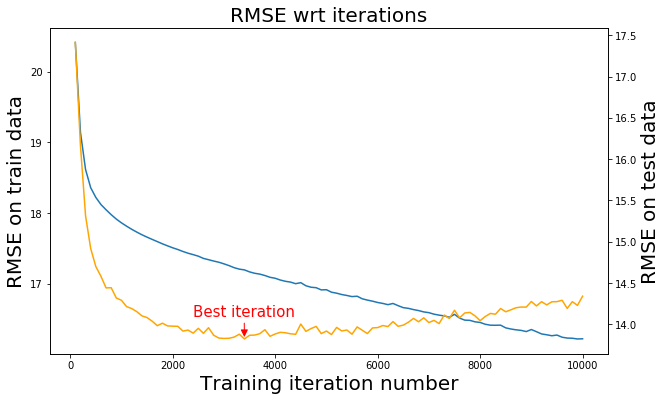

In [51]:
# Plot the result
trn_m = 1#np.mean((labels-np.mean(labels))**2)**0.5
val_m = 1#np.mean((labels-np.mean(labels_val))**2)**0.5

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.plot([x["global_step"] for x in trn_mse],
        [x["mse"]**0.5/trn_m for x in trn_mse])
ax1.set_ylabel('RMSE on train data',size=20)
ax1.set_xlabel('Training iteration number',size=20)
ax1.set_title("RMSE wrt iterations",size=20)

ax2 = ax1.twinx()
ax2.plot([x["global_step"] for x in val_mse],
        [x["mse"]**0.5/val_m for x in val_mse], 'orange')
ax2.set_ylabel('RMSE on test data',size=20)

plt.annotate("Best iteration", xy=(3400,13.823),xytext = (2400,14.1),color="r",size=15,
             arrowprops={'arrowstyle':'-|>',"color":"r"})
plt.show()

In [48]:
# Best iteration is 3000
# Best RMSE on validation set is 13.68726477573279 (Target is <15)
print("The baseline RMSE:", 31.2)
print("The target RMSE:", 15)
print("best iteration:",val_mse[np.argmin([x["mse"] for x in val_mse])]["global_step"])
print("RMSE on train set:",trn_mse[np.argmin([x["mse"] for x in val_mse])]["mse"]**0.5)
print("best RMSE on validation data:",np.min([x["mse"]**0.5 for x in val_mse]))

The baseline RMSE: 31.2
The target RMSE: 15
best iteration: 3400
RMSE on train set: 17.194795149248197
best RMSE on validation data: 13.823728666433093
